In [1]:
import numpy as np
import matplotlib.pyplot as plt

### With this code I do the numerical simulation for the tent map and upside-down tent map in combination with SAC learning. It also gives multiple graphs which can be used to give information about the dynamics.

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14540\2674256256.py:22: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


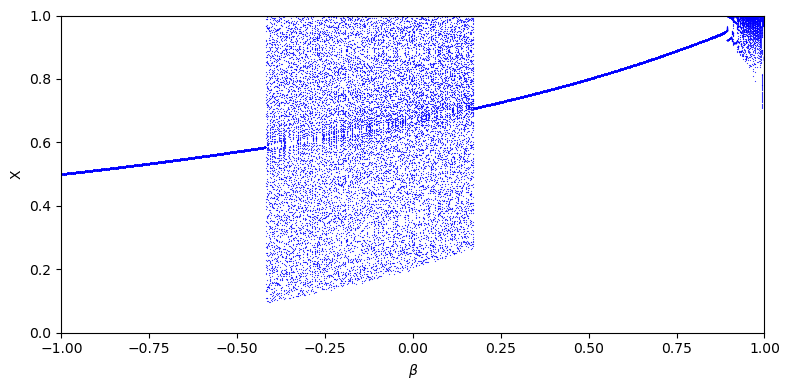

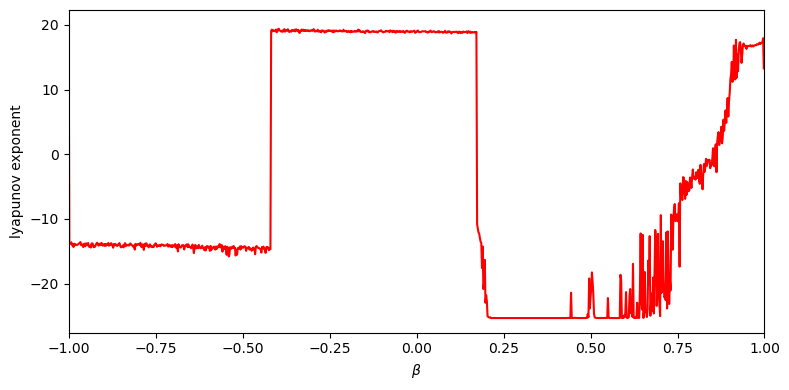

In [22]:
# Define the asymmetric tent map
def tent_map_scalar(x, beta):
    if x <= (1 + beta) / 2 and x >= 0:
        return 2 * x / (1 + beta)
    elif x > (1 + beta) / 2 and x <= 1:
        return 2 * (1 - x) / (1 - beta)
    elif x < 0:
        return 0
    else:
        return 1

def tent_map_scalar_ud(x, beta):
    return 1 - tent_map_scalar(x, beta)

def SAC_learning_forecast(x, a, b, t):
    forecast = a[t - 2] + b[t - 2]**2 * (x[t - 2] - a[t - 2])
    return forecast

def SAC_learning_update(x, a, b, r, t):
    r[t] = r[t - 1] + (t / (t + 1) * (x[t] - a[t - 1])**2 - r[t - 1]) / (t + 1)
    a[t] = a[t - 1] + (x[t] - a[t - 1]) / (t + 1)
    b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])
    return a, b, r

# Simulate the system under naïve learning
def simulate_SAC_learning(beta, x0, tent, T=1000, burn_in=200):
    x_vals = np.zeros(T)
    a = np.zeros(T)
    b = np.zeros(T)
    r = np.zeros(T)
    forecast_vals = np.zeros(T + 1)
    forecast_vals[0] = x0
    x_vals[0] = x0
    a[0] = x0
    if tent=="tent":
        for t in range(1, T):
            forecast = SAC_learning_forecast(x_vals, a, b, t + 1)
            x_vals[t] = tent_map_scalar(forecast, beta)
            a, b, r = SAC_learning_update(x_vals, a, b, r, t)
    elif tent=="tent_ud":
        for t in range(1, T):
            forecast = SAC_learning_forecast(x_vals, a, b, t + 1)
            x_vals[t] = tent_map_scalar_ud(forecast, beta)
            a, b, r = SAC_learning_update(x_vals, a, b, r, t)
    # Do not include the first 200 values
    return x_vals[burn_in:], a[burn_in:], b[burn_in:]

def lyapunov_exponent_SAC_learning(beta, x0, tent, T=5000, burn_in=1000, eps=1e-9):
    x_base = simulate_SAC_learning(beta, x0, tent, T=T, burn_in=burn_in)[0]
    x_pert = simulate_SAC_learning(beta, x0 + eps, tent, T=T, burn_in=burn_in)[0]
    dist = np.abs(x_pert - x_base) + 1e-20
    return np.log(dist[burn_in:] / eps).mean()

def orbit_and_lyapunov_SAC_learning(seed, n_skip, n_iter, tent, step=0.001):
    beta_range = np.linspace(-1, 1, int(1 / step), endpoint=False)
    lyap = []
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for beta in beta_range:
        x_vals = simulate_SAC_learning(beta, seed, tent, T=n_iter + n_skip, burn_in=n_skip)[0]
        ax1.scatter(np.full_like(x_vals, beta), x_vals, s=0.75, color='blue', alpha=0.8, linewidths=0)
        lyap.append(lyapunov_exponent_SAC_learning(beta, seed, tent))
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel('X')
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/SAC_learning_orbit_diagram.png")
    else:
        plt.savefig("Images/SAC_learning_orbit_diagram_ud.png")
    plt.show()
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(beta_range, lyap, color='red')
    ax2.set_xlim(-1, 1)
    ax2.set_xlabel(r'$\beta$')
    ax2.set_ylabel('lyapunov exponent')
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/SAC_learning_lyapunov.png")
    else:
        plt.savefig("Images/SAC_learning_lyapunov_ud.png")
    plt.show()

orbit_and_lyapunov_SAC_learning(seed=0.5, n_skip=2000, n_iter=50, tent="tent", step=0.001)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14540\108120524.py:22: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


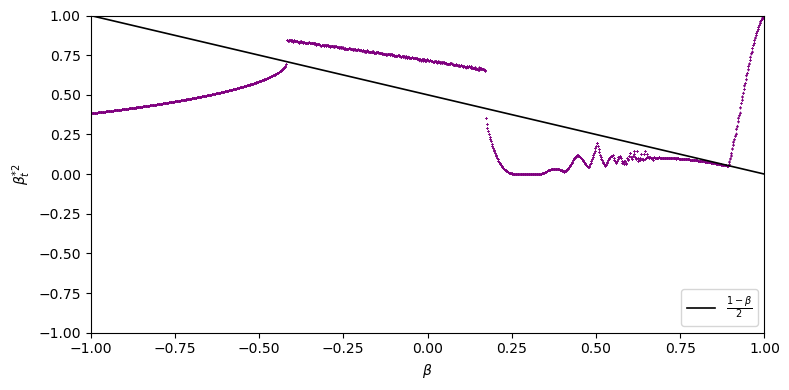

In [10]:
def orbit_SAC_learning_b(seed, n_skip, n_iter, tent, step=0.001):
    beta_range = np.linspace(-1, 1, int(1 / step), endpoint=False)

    fig1, ax1 = plt.subplots(figsize=(8, 4))

    for beta in beta_range:
        b_vals = simulate_SAC_learning(beta, seed, tent, T=n_iter + n_skip, burn_in=n_skip)[2]
        ax1.scatter(np.full_like(b_vals**2, beta), b_vals**2, s=0.75, color='purple', alpha=0.8, linewidths=0)
    ax1.plot(beta_range, (1 - beta_range) / 2, color='black', lw=1.2, label=r'$\frac{1-\beta}{2}$')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel(r'$\beta_t^{*2}$')
    ax1.legend(loc='lower right')
    plt.tight_layout()

    if tent == "tent":
        plt.savefig("Images/SAC_learning_orbit_diagram_b.png")
    else:
        plt.savefig("Images/SAC_learning_orbit_diagram_b_ud.png")
    plt.show()

orbit_SAC_learning_b(0.5, 2000, 50, "tent", step=0.001)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14540\108120524.py:22: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


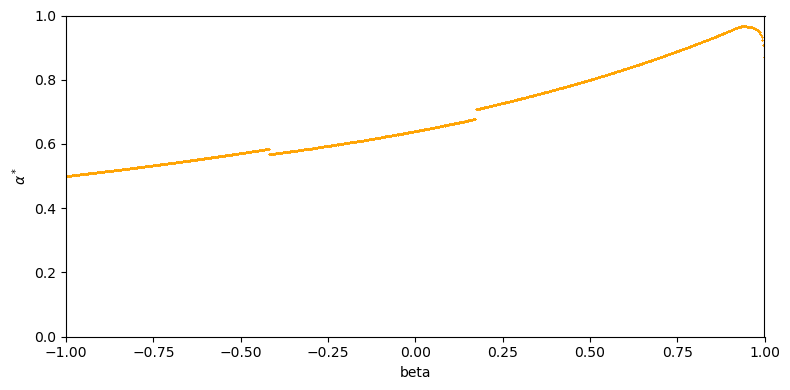

In [11]:
def orbit_SAC_learning_a(seed, n_skip, n_iter, tent, step=0.001):
    beta_range = np.linspace(-1, 1, int(1 / step), endpoint=False)
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for beta in beta_range:
        a_vals = simulate_SAC_learning(beta, seed, tent, T=n_iter + n_skip, burn_in=n_skip)[1]
        ax1.scatter(np.full_like(a_vals, beta), a_vals, s=0.75, color='orange', alpha=0.8, linewidths=0)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('beta')
    ax1.set_ylabel(r'$\alpha^*$')
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/SAC_learning_orbit_diagram_a.png")
    else:
        plt.savefig("Images/SAC_learning_orbit_diagram_a_ud.png")
    plt.show()

orbit_SAC_learning_a(0.5, 10000, 50, "tent", step=0.001)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24820\2449487141.py:22: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


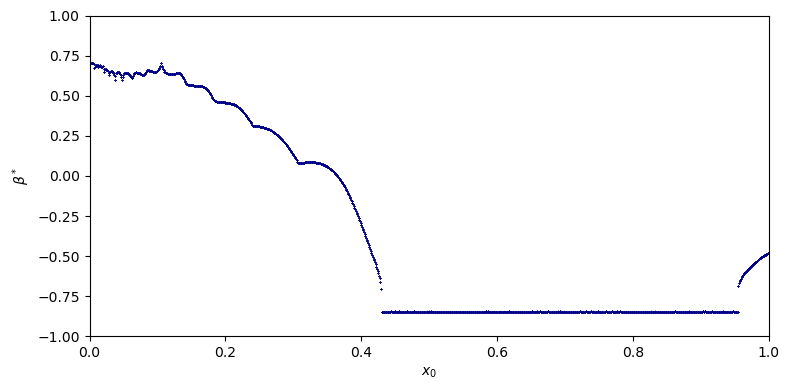

In [17]:
def orbit_SAC_learning_b_x0(beta, n_skip, n_iter, tent, step=0.001):
    x0_vals = np.linspace(0, 1, int(1 / step), endpoint=False)
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for x0 in x0_vals:
        b_vals = simulate_SAC_learning(beta, x0, tent, T=n_iter + n_skip, burn_in=n_skip)[2]
        ax1.scatter(np.full_like(b_vals, x0), b_vals, s=0.75, color='darkblue', alpha=0.8, linewidths=0)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_xlabel(r'$x_0$')
    ax1.set_ylabel(r'$\beta^*$')
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/SAC_learning_orbit_diagram_b_x0.png", dpi=300)
    else:
        plt.savefig("Images/SAC_learning_orbit_diagram_b_x0_ud.png", dpi=300)
    plt.show()

orbit_SAC_learning_b_x0(0.0, 10000, 50, "tent", step=0.001)

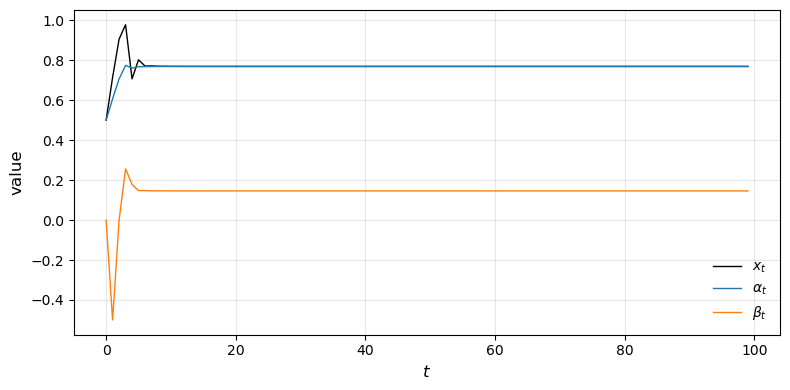

In [19]:
x, a, b = simulate_SAC_learning(beta=0.4, x0=0.5, tent="tent", T = 100, burn_in=0)

def plot_SAC_series(x, a, b, tent):
    colors = ["black", "tab:blue", "tab:orange"]
    plt.figure(figsize=(8, 4))
    t = range(len(x))
    plt.plot(t, x, color=colors[0], label=r"$x_t$", linewidth=1)
    plt.plot(t, a, color=colors[1], label=r"$\alpha_t$", linewidth=1)
    plt.plot(t, b, color=colors[2], label=r"$\beta_t$", linewidth=1)
    plt.xlabel(r"$t$", fontsize=12)
    plt.ylabel("value", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/SAC_learning_series_combined.png")
    elif tent == "tent_ud":
        plt.savefig("Images/SAC_learning_series_combined_ud.png")
    plt.show()

plot_SAC_series(x, a, b, tent="tent")

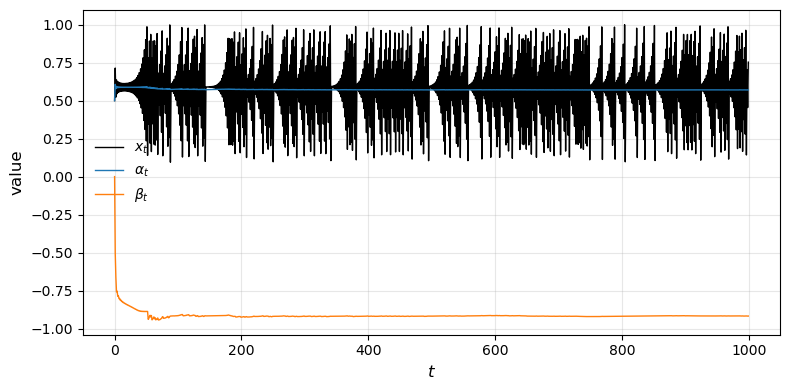

In [6]:
x, a, b = simulate_SAC_learning(beta=-0.4, x0=0.5, tent="tent", T = 1000, burn_in=0)

def plot_SAC_series_2(x, a, b, tent):
    colors = ["black", "tab:blue", "tab:orange"]
    plt.figure(figsize=(8, 4))
    t = range(len(x))
    plt.plot(t, x, color=colors[0], label=r"$x_t$", linewidth=1)
    plt.plot(t, a, color=colors[1], label=r"$\alpha_t$", linewidth=1)
    plt.plot(t, b, color=colors[2], label=r"$\beta_t$", linewidth=1)
    plt.xlabel(r"$t$", fontsize=12)
    plt.ylabel("value", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/SAC_learning_series_combined_2.png")
    elif tent == "tent_ud":
        plt.savefig("Images/SAC_learning_series_combined_2_ud.png")
    plt.show()

plot_SAC_series_2(x, a, b, tent="tent")

### Now we go over to the upside-down tent map, again in combination with SAC learning

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14540\108120524.py:22: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


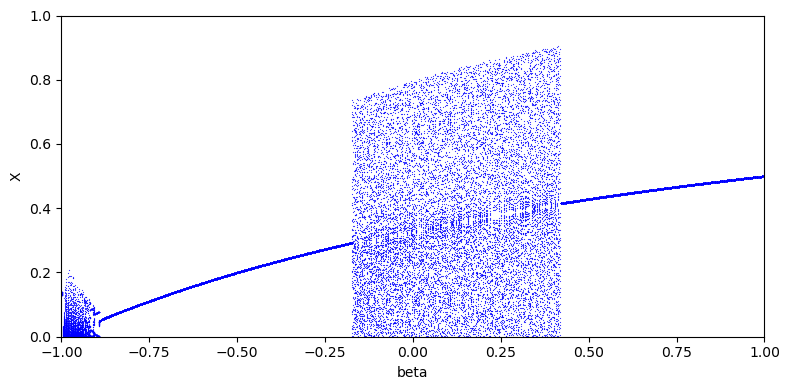

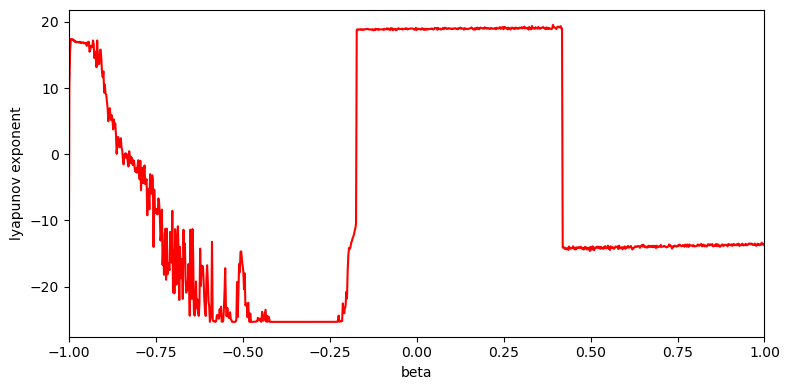

In [20]:
orbit_and_lyapunov_SAC_learning(0.5, 2000, 50, "tent_ud", step=0.001)

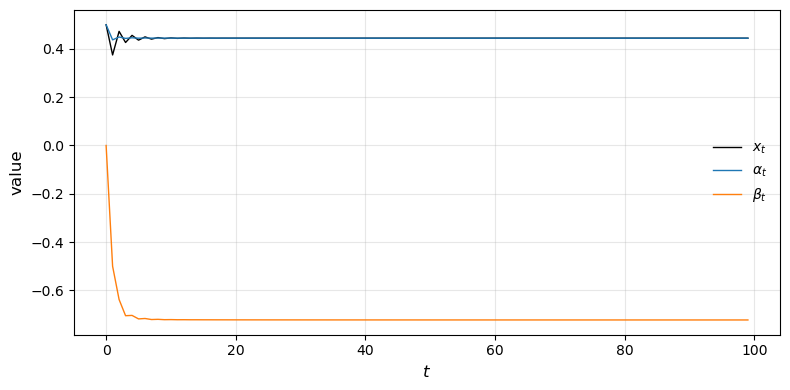

In [17]:
x, a, b = simulate_SAC_learning(beta=0.6, x0=0.5, tent="tent_ud", T = 100, burn_in=0)

plot_SAC_series(x, a, b, "tent_ud")

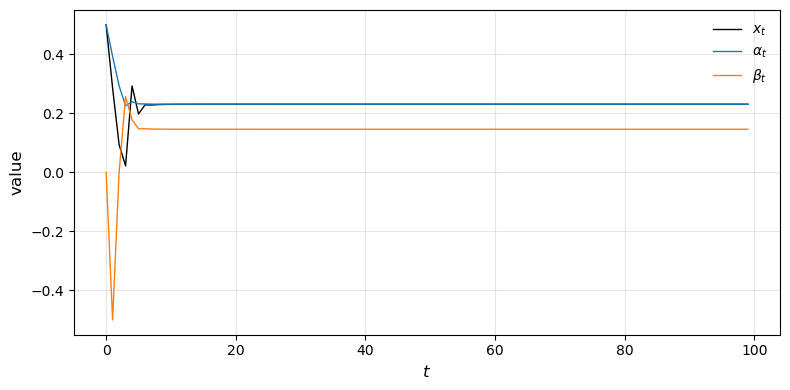

In [18]:
x, a, b = simulate_SAC_learning(beta=-0.4, x0=0.5, tent="tent_ud", T = 100, burn_in=0)

plot_SAC_series_2(x, a, b, "tent_ud")

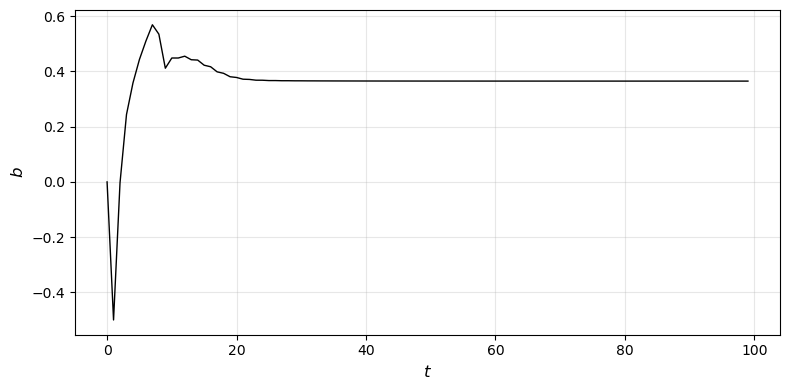

In [26]:
plot_b_series(b, "tent_ud")